In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# train_ch6所需的所有组件
import torch
from torch import nn
from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline
import torchvision
from torch.utils import data
from torchvision import transforms

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# 更新器
def sgd(params, lr, batch):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 计时器
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times)/len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()


# 精准度的计算
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
          device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
              # BERT微调所需
              X = [x.to(device) for x in X]
            else:
              X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 参数储存器
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 画图部分
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        # d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# mini-batch取数据
def get_dataloader_workers():
  #使用四个线程
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()), data.DataLoader(mnist_test, batch_size, shuffle=False,
                num_workers=get_dataloader_workers()))

def try_gpu(i=0):
  """如果存在，则返回gpu(i)，否则返回cpu()"""
  if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
  return torch.device('cpu')


  # 训练
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [8]:
# 文本处理组件
import torch
# from d2l import torch as d2l
import collections
import re
# from d2l import torch as d2l

def read_time_machine():
    with open('/content/drive/MyDrive/timemachine.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower()
           for line in lines]


def tokenize(lines, token='word'):
    if token=='word':
        return [line.split() for line in lines]
    elif token=='char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型: ' + token)


class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens==None:
            tokens = []
        if reserved_tokens==None:
            reserved_tokens = []
#         按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in
                           enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs



def count_corpus(tokens):
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [9]:
# 语言模型和数据集
import random
import torch

def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [10]:
lines = read_time_machine()
print(type(lines))
print(f'文本总数: {len(lines)}')
print(lines[0])
print(lines[10])

<class 'list'>
文本总数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [11]:
# 8.5 循环神经网络的从零开始实现
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F

# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size=shape, device=device) * 0.01

  W_xh = normal((num_inputs, num_hiddens))
  W_hh = normal((num_hiddens, num_hiddens))
  b_h = torch.zeros(num_hiddens, device=device)
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)

  params = [W_xh, W_hh, b_h, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

# H /in R^{n * h}
def init_rnn_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn(inputs, state, params):
  # inputs的形状：（时间步数量=k, 批量大小=n，词表大小=d）
  W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []
  for X in inputs:
    H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
    Y = torch.mm(H, W_hq) + b_q
    outputs.append(Y)
    # return size为 Y \in R^{(k*n) * q} and H \in R^{n * h}
  return torch.cat(outputs, dim=0), (H,)

class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, Timer()
    metric = Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


In [13]:
num_hiddens = 512
num_epochs, lr = 500, 1
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)

predict_ch8('time traveller ', 10, net, vocab, try_gpu())

'time traveller bsgfueldes'

困惑度 10.9, 71691.1 词元/秒 cuda:0
time travellere the the the the the the the the the the the the 
travellere the the the the the the the the the the the the 


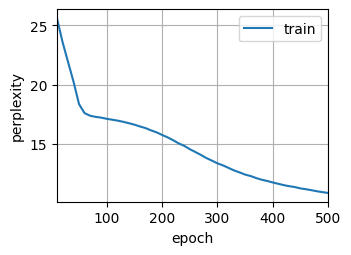

In [14]:
train_ch8(net, train_iter, vocab, lr, num_epochs, try_gpu())

困惑度 10.9, 92129.6 词元/秒 cuda:0
time travellere the the the the the the the the the the the the 
travellere the the the the the the the the the the the the 


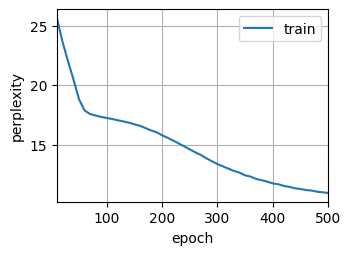

In [37]:
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, try_gpu(),
          use_random_iter=True)

In [15]:
# 8.6 循环神经网络的简洁实现
import torch
from torch import nn
from torch.nn import functional as F

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

class RNNModel(nn.Module):
  def __init__(self, rnn_layer, vocab_size, **kwargs):
    super(RNNModel, self).__init__(**kwargs)
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    else:
      self.num_directions = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

  def forward(self, inputs, state):
    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    Y, state = self.rnn(X, state)
    output = self.linear(Y.reshape((-1, Y.shape[-1])))
    return output, state

  def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

困惑度 1.3, 289071.0 词元/秒 cuda:0
time travelleryou can shoughis s all he bug now megint one time 
travelleryou can showlbles thethedsto sasaid the time trave


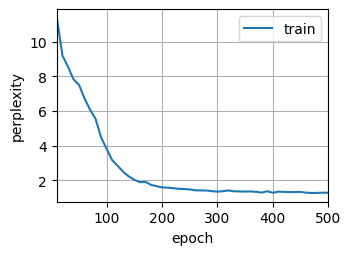

In [15]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [21]:
# 9.1.2 从0开始实现GRU
import torch
from torch import nn
# from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

KeyboardInterrupt: ignored

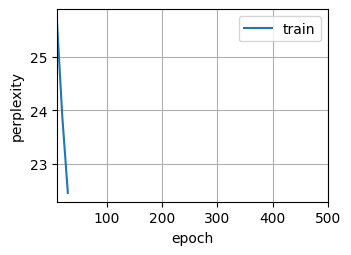

In [22]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.0, 258738.3 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


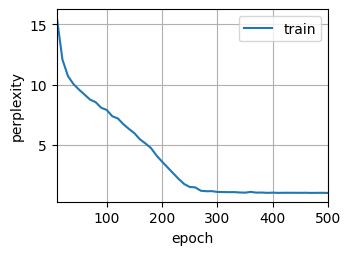

In [16]:
# 9.1.3 GRU的简洁实现
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [24]:
# 9.2.2 从零开始实现LSTM
import torch
from torch import nn
# from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc,
     W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
      I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
      F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
      O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
      C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
      C = F * C + I * C_tilda
      H = O * torch.tanh(C)
      Y = (H @ W_hq) + b_q
      outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))


KeyboardInterrupt: ignored

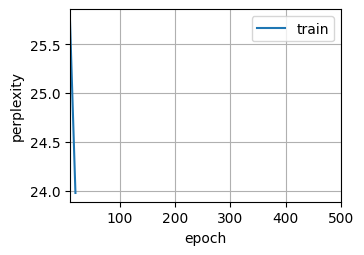

In [25]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.0, 371243.3 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


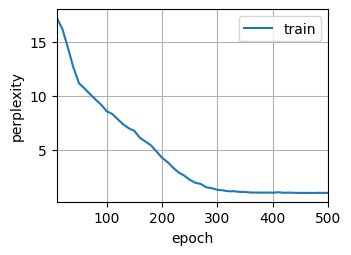

In [26]:
# 9.2.3 简洁实现LSTM

num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [12]:
def read_data_nmt():
  with open('/content/drive/MyDrive/fra.txt', 'r', encoding='utf-8') as f:
    return f.read()

In [14]:
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [15]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [16]:
def tokenize_nmt(text, num_examples=None):
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if num_examples and i > num_examples:
      break
    parts = line.split('\t')
    if len(parts) == 2:
      source.append(parts[0].split(' '))
      target.append(parts[1].split(' '))
  return source, target

In [17]:
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

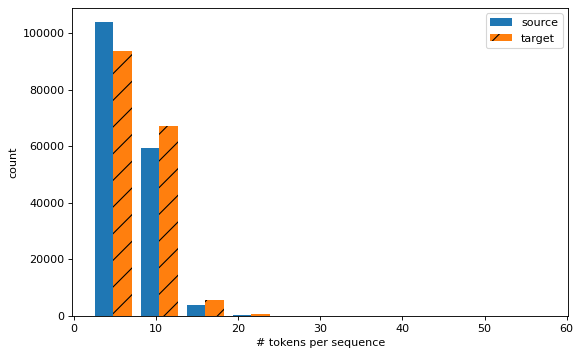

In [27]:
from matplotlib import pyplot as plt
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    # plt.set_figsize()
    plt.figure(figsize=(8,5), dpi=80)
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

In [18]:
src_vocab = Vocab(source, min_freq=2,
                  reserved_tokens=['<pad>', '<bos>', '<eos>'])

len(src_vocab)

10012

In [19]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [20]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [23]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [26]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[  0,   0,   4,   3,   1,   1,   1,   1],
        [  6, 124,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[83,  0,  0,  4,  3,  1,  1,  1],
        [ 6, 27,  7,  0,  4,  3,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([5, 6])
